In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pomegranate import *
from scipy import stats

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine
#from model.featureConfig import FeatureConfig_G3
#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

## Configuration and Data Loading

In [2]:
# Setup configuration
cfg = config.ResearchConfig_MonOnly
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:06<00:00, 392.02it/s]


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [3]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: outcome.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.
+ Add feature: mark.
Aggregate data over customer months.


100%|██████████| 49/49 [00:40<00:00,  1.20it/s]


In [4]:
ftr_list = ['num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num',
            'last_access', 
            'active',
            'usage', 'usage_complete', 'usage_incomplete', 'rate_incomplete_usage',
            'num_pass', 'num_replay', 'num_fail', 'rate_pass', 'rate_fail',
            'num_assess', 'assess', 'num_replay', 'rate_assess',
            'sum_help',
            'usage_sd2', 'num_sd2',
            'usage_sd0', 'num_sd0',
            'rate_stackDepth23_num', 'rate_stackDepth23_usage',
            'age',
            'mark_complete', 'mark_incomplete',
            'progress', 'progress_delta',
            'calendar_month',
           ]

data_engine.select_features(ftr_list)

X = data_engine.data_
y = data_engine.target_

df_whizz1 = data_engine.df_whizz_

## Feature Distribution (Raw)

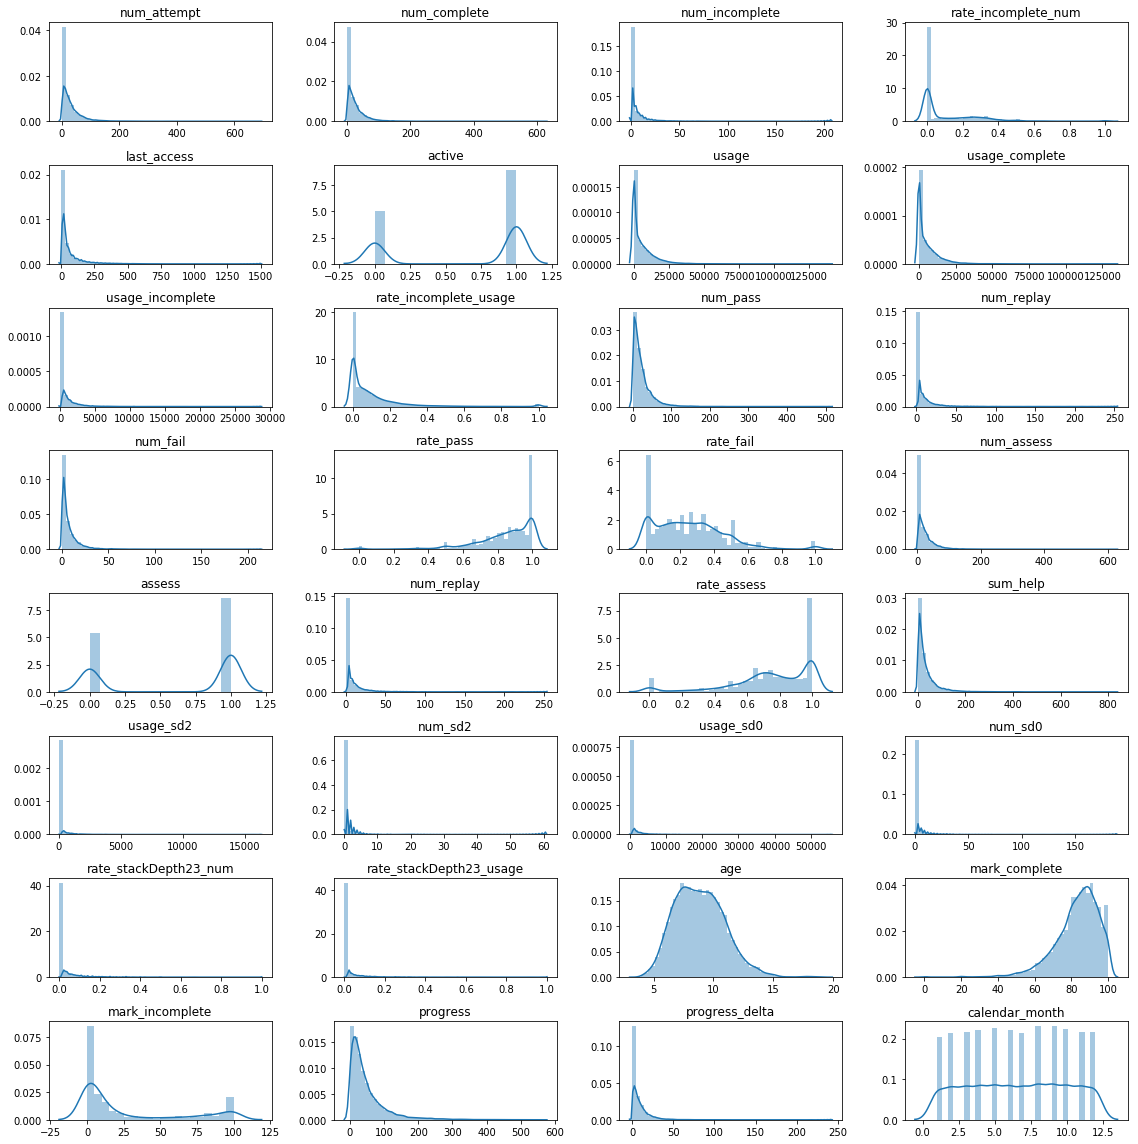

In [5]:
ftr_list_nontransform = []
utility.plotlib.feature_distribution(
    df_whizz1, ftr_list, 4, cfg, 
    transform=False, ftr_list_nontransform=ftr_list_nontransform)

## Groups

In [8]:
mask_inactive = df_whizz1.active==0
mask_churn = df_whizz1.churn==1

mask_noassess = df_whizz1.assess==0

print('Churn rate for subscribers having no assessment = {:.2f}%.'.\
      format(df_whizz1[mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[mask_noassess&~mask_inactive].shape[0]*100))
print('Churn rate for subscribers having assessment = {:.2f}%.'.\
      format(df_whizz1[~mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[~mask_noassess&~mask_inactive].shape[0]*100))

Churn rate for subscribers having no assessment = 16.94%.
Churn rate for subscribers having assessment = 10.21%.


## Initial Diagnostics of Features

In [13]:
df_whizz_noassess = df_whizz1[mask_noassess&~mask_inactive]
df_whizz_noassess.columns

Index(['num_attempt', 'num_complete', 'num_incomplete', 'rate_incomplete_num',
       'churn', 'last_access', 'active', 'calendar_month', 'holiday',
       'usage_complete', 'usage_incomplete', 'usage', 'rate_incomplete_usage',
       'progress', 'progress_delta', 'age', 'num_pass', 'num_fail', 'assess',
       'num_assess', 'num_replay', 'rate_assess', 'rate_pass', 'rate_fail',
       'rate_fwrd', 'rate_back', 'num_sd0', 'num_sd1', 'num_sd2', 'help_sd0',
       'help_sd1', 'help_sd2', 'usage_sd0', 'usage_sd1', 'usage_sd2',
       'sum_help', 'rate_stackDepth23_num', 'rate_stackDepth23_usage',
       'mark_complete', 'mark_incomplete'],
      dtype='object')

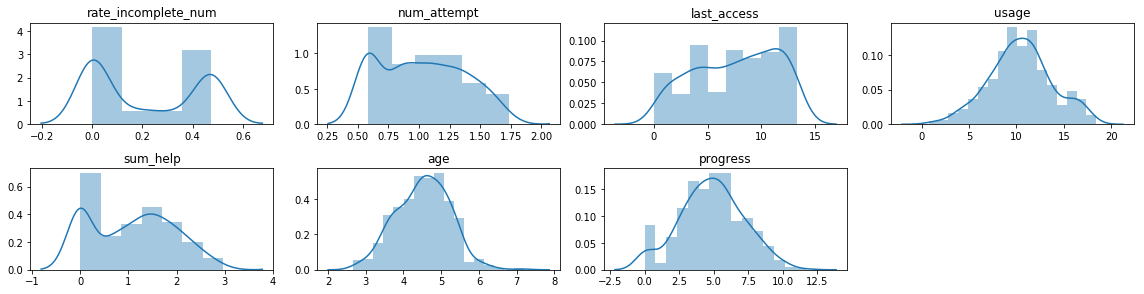

In [20]:
ftr_list_independent = ['rate_incomplete_num'
                       ]

ftr_list_multivariate = ['num_attempt',
            'last_access', 
            'usage',
            'sum_help',
            'age',
            'progress',
           ]

ftr_list = ftr_list_independent + ftr_list_multivariate

ftr_list_nontransform = []
utility.plotlib.feature_distribution(
    df_whizz_noassess, ftr_list, 4, cfg, 
    transform=True, ftr_list_nontransform=ftr_list_nontransform)

C:\Users\User\Anaconda3\lib\site-packages\seaborn\palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


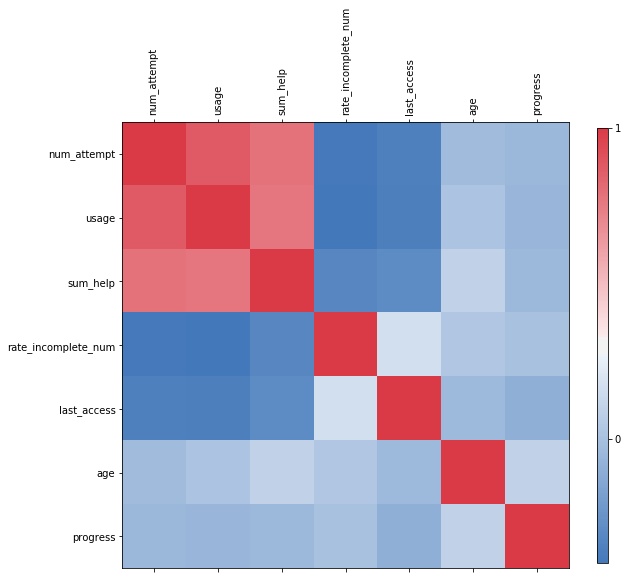

In [21]:
utility.plotlib.feature_correlation(df_whizz_noassess[ftr_list])

In [22]:
def density_mixtureModel(ftr_str, x, model, hist_bin):
    
    xbin = np.arange(x.min()-(x.max()-x.min())/50., x.max()*1.1, (x.max()-x.min())/hist_bin)
    xs = np.arange(x.min()-(x.max()-x.min())/50., x.max()*1.1, (x.max()-x.min())/100.)
    prob = model.probability(xs)

    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.title(ftr_str, fontsize=12)
    plt.hist(x, bins=xbin, alpha=0.6, density=True)
    plt.plot(xs, prob, color='k')

    plt.ylabel("Density", fontsize=12); plt.yticks(fontsize=12)
    plt.xlabel("Value", fontsize=12); plt.yticks(fontsize=12)
    
def compare_transformed_singleValueRemoved(df, ftr_str, remove_point):
    series = df[ftr_str]
    x = series.values

    # Box-cox transformation
    xt,_ = stats.boxcox(x+1)
    
    # Standardise
    from sklearn.preprocessing import MinMaxScaler
    xt1 = xt.reshape(-1, 1)
    xt1 = MinMaxScaler().fit(xt1).transform(xt1)
    xt1 *= 99
    xt1 += 1
    xt = xt1.reshape(-1, 1)

    # Extract non-zero elements
    if remove_point=='min':
        x_rm = x[np.where(x!=x.min())[0].tolist()]
        xt_rm = xt[np.where(xt!=xt.min())[0].tolist()]
    else:
        x_rm = x[np.where(x!=x.max())[0].tolist()]
        xt_rm = xt[np.where(xt!=xt.max())[0].tolist()]
    
    # Plot
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(141)
    sns.distplot(x)

    ax = fig.add_subplot(142)
    sns.distplot(x_rm)

    ax = fig.add_subplot(143)
    sns.distplot(xt)

    ax = fig.add_subplot(144)
    sns.distplot(xt_rm)


In [28]:
def independent_component(ftr_str, plot=True):
    from sklearn.preprocessing import MinMaxScaler
    
    ftrConfig = FeatureConfig_G2()

    ftr_config = eval('ftrConfig.'+ftr_str)

    if plot:
        compare_transformed_singleValueRemoved(df_whizz_noassess, ftr_str, 'min')
        
    # Define the data to be fitted
    x_raw = df_whizz_noassess[ftr_str].values
    x = x_raw * ftr_config.multiplierPre
    x += ftr_config.shiftPre
    # Box-cox transform
    if ftr_config.bcTransform:
        xt, bc_param = stats.boxcox(x)
        x = xt
    x = x.reshape(-1,1)
    # Standardise
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    x *= 99
    x += 1
    # Post-BoxCox transform
    x *= ftr_config.multiplierPost
    x += ftr_config.shiftPost

    # Define the list of distributions to be mixed
    distribution_list = ftr_config.distributionList

    gmm = GeneralMixtureModel(distribution_list)
    print('Improvement = {}'.format(gmm.fit(x, verbose=False)))
    print('Weights = {}'.format(np.exp(gmm.weights)))

    if plot:
        density_mixtureModel(ftr_str, x, gmm, hist_bin=35)
    
    group = gmm.predict(x)
    
    return gmm, group

In [30]:
class FeatureAttribute(object):
    """Struct-like class for configuring data transformation and distributional 
    modelling for different features. 
    """
    name = ''
    
    multiplierPre = 1.
    shiftPre = 0.
    bcTransform = False
    multiplierPost = 1.
    shiftPost = 0.
    distributionList = []

class FeatureConfig_G2(object):
    """Feature configuration for Group 2.
    """

    def __init__(self):

        self.rate_incomplete_num = FeatureAttribute()
        self.rate_incomplete_num.name = 'rate_incomplete_num'
        self.rate_incomplete_num.shiftPre = 1.
        self.rate_incomplete_num.bcTransform = True
        self.rate_incomplete_num.distributionList = [UniformDistribution(0,10),
                                                     UniformDistribution(90, 100),
                                                     NormalDistribution(50, 20)]

## Rate of number of incomplete attempts

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Improvement = 152.59507332897124
Weights = [0.44009209 0.34682162 0.21308629]


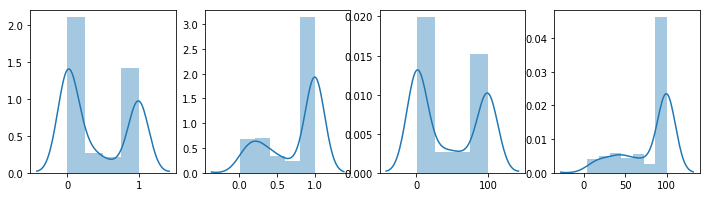

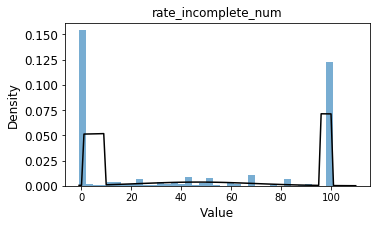

In [115]:
ftr_str = 'rate_incomplete_num'
m, g = independent_component(ftr_str)

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import mixture

X = np.array(df_whizz_noassess[ftr_list_multivariate]+1)
Xt = X
for i in range(0, X.shape[1]):
    xt, _ = stats.boxcox(X[:,i])
    Xt[:, i] = xt
Xt_scaled = MinMaxScaler().fit(Xt).transform(Xt)

y = df_whizz_noassess.churn.values

Initialization 0
  Iteration 0	 time lapse 0.00498s	 ll change inf
  Iteration 100	 time lapse 0.14362s	 ll change 0.00000
Initialization converged: True	 time lapse 0.15559s	 ll 1.81876


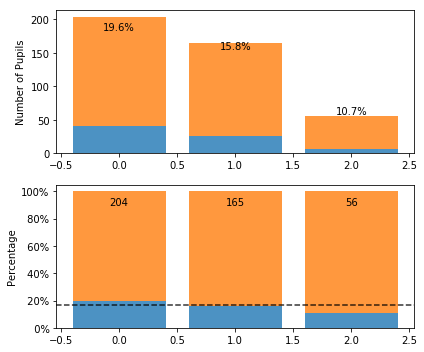

In [89]:
n_components = 3

gmm = mixture.GaussianMixture(
    n_components=n_components, 
    covariance_type='full',
    init_params='random',
    verbose=2, verbose_interval=100,
    n_init=1, 
    tol=1e-6, max_iter=1000).fit(Xt_scaled)

group_m = gmm.predict(Xt_scaled)
utility.plotlib.component_bar(y, group_m, n_components)

Initialization 0
  Iteration 0	 time lapse 0.00896s	 ll change inf
Initialization converged: True	 time lapse 0.22439s	 ll 3135.96290


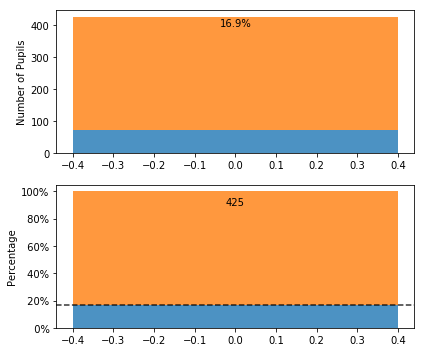

In [74]:
n_components = 10
n_features = len(ftr_list_multivariate)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-6, max_iter=10000, n_init=1, 
    verbose=2, verbose_interval=100).fit(Xt_scaled)

group_m = dpgmm.predict(Xt_scaled)

utility.plotlib.component_bar(y, group_m, n_components)

In [90]:
n_var_indep = len(ftr_list_independent)
# Combine the group assignemnts from multivariate Gaussian features and independent features
group = []
col_name = []
group.append(group_m)
col_name.append('multi')
for i_var in range(n_var_indep):
    ftr_str = ftr_list_independent[i_var]
    m, g = independent_component(ftr_str, plot=False)
    group.append(g)
    col_name.append('indep'+str(i_var))

Improvement = 152.59507332897124
Weights = [0.44009209 0.34682162 0.21308629]


In [91]:
# Identify unique groups/labels and frequency
label = np.array(group).transpose()
unq_rows, count = np.unique(label, axis=0, return_counts=True)
map_group_count = {tuple(i):j for i,j in zip(unq_rows,count)}

In [92]:
# Compute churn rate within each group
map_group_churn = {}
for k in range(0, len(unq_rows)):
    indices = [i for i, x in enumerate(label.tolist()) if x==unq_rows[k].tolist()]
    l = y[indices]
    map_group_churn[tuple(unq_rows[k])] = l.sum()*1. / len(l)

In [93]:
# Construct the grouping data frame
df_grouping = pd.DataFrame(unq_rows, columns=col_name)
df_grouping = df_grouping.assign(count=count,
                   churn=list(map_group_churn.values()))
df_grouping.sort_values(by='churn', ascending=False, inplace=True)
df_grouping['cumcount'] = df_grouping['count'].cumsum()

Text(0,0.5,'Group churn rate')

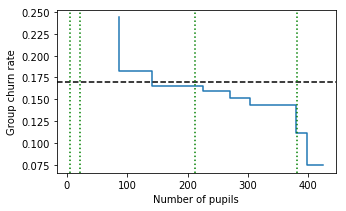

In [94]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.step(df_grouping['cumcount'].values, df_grouping['churn'].values)
ax.axhline(y=y.sum()/len(y), linestyle='--', color='k')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 1), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 5), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 50), linestyle=':', color='g')
ax.axvline(x=np.percentile(np.arange(0, len(y)), 90), linestyle=':', color='g')
ax.set_xlabel('Number of pupils')
ax.set_ylabel('Group churn rate')
#ax.set_xscale('log')
#ax.set_yscale('log')

In [98]:
agg_anchors = [0, 90, 100]
num_agg = len(agg_anchors) - 1
agg_churn = []
agg_count = []
l = np.arange(0, len(y)) + 1
for i in range(len(agg_anchors)):
    if i==0:
        continue
    else:
        lower = np.percentile(l, agg_anchors[i-1])
        upper = np.percentile(l, agg_anchors[i])
    
    if i==len(agg_anchors)-1:
        mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<=upper)
    else:
        mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<upper)
        
    df_grouping.loc[mask, 'agg'] = i
    df = df_grouping[mask]
    temp = df['churn'] * df['count']
    num_churn = temp.sum()
    agg_count.append(df['count'].sum())
    agg_churn.append(num_churn*1./agg_count[i-1])

data = {'count': agg_count,
        'churn': agg_churn
    }
df_grouping_agg = pd.DataFrame(data)
df_grouping_agg['cumcount'] = df_grouping_agg['count'].cumsum()

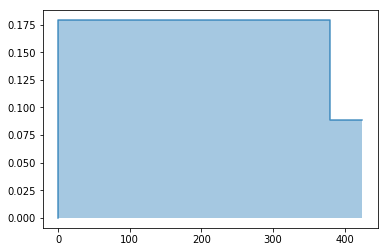

In [99]:
xp = df_grouping_agg['cumcount'].values
yp = df_grouping_agg['churn'].values

xp = np.insert(xp, 0, 0)
yp = np.insert(yp, 0, 0)

plt.fill_between(xp, yp, step='pre', alpha=0.4)
plt.plot(xp, yp, drawstyle="steps", alpha=0.8)
#plt.step(df_countchurn['cumcount'].values, df_countchurn['churn'].values, alpha=0.8)

In [100]:
df_grouping_agg

,churn,count,cumcount
0,0.178947,380,380
1,0.088889,45,425
